# Linear approximation of NN

This notebook aims to evaluate the linear approximation of NN. In particular, when NN can be linearized without significant error, NN function is equivalent as NTK. This condition indeed holds when $m$ and $\alpha$ is large enough and learning rate is small. However, we should mention that the convergence to NTK also relies on the complexity of data. Intuitively, when data is more complex, such as some image data, NN has to learn effective feature to get a good performance, while toy data can be easily classified with simple feature.

## Toy data

In [1]:
from sklearn.datasets import make_classification
import torch
import numpy as np
import random
from torch import optim, nn

In [2]:
SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
X, y = make_classification(n_samples=1000, n_features=100, n_informative=4,
                           n_redundant=10, n_repeated=10, n_classes=2,
                           n_clusters_per_class=2, weights=None, flip_y=0.01,
                           class_sep=1.0, hypercube=True, shift=0.0, scale=1.0,
                           random_state=SEED)

X_tr,y_tr = X.astype('float32')[:500],y.astype('float32')[:500]
X_te,y_te = X.astype('float32')[500:],y.astype('float32')[500:]


In [4]:
X_tr = torch.from_numpy(X_tr).cuda()
X_te = torch.from_numpy(X_te).cuda()
y_tr = torch.from_numpy(y_tr).cuda()
Y_tr = y_tr.view(-1,1)
y_te = torch.from_numpy(y_te).cuda()
Y_te = y_te.view(-1,1)

In [5]:

import copy

def ntk(model, model0, x):
    h = lambda x:model[0](x)
    h0 = lambda x:model0[0](x)
    out_h0 = h0(x)
    batch = x.shape[0]
    hidden = out_h0.shape[1]
    single_out_size = out_h0.shape[1]
    vector = torch.ones(hidden).cuda()
    jac = torch.zeros(batch,out_h0.shape[1],x.shape[1]).cuda()
    #print(jac.shape)
    for i in range(batch):  # for loop over data points
        model0.zero_grad()
        p_grad = torch.autograd.grad(out_h0[i], model0[0][0].weight, 
                              grad_outputs=vector, 
                               retain_graph=True,
                               create_graph=True
                              )[0]
        jac[i] = p_grad

    delta_theta = model[0][0].weight.data - model0[0][0].weight.data # h x X
    delta_theta = torch.unsqueeze(delta_theta,0) # 1 x h x X
    ker_tangent = torch.sum(delta_theta * jac,2) # b x h
    u_now =  model[1].weight.data # 1 x h
    tangent_term = torch.sum(u_now * ker_tangent,1).view(-1,1) # b x 1
    random_term = torch.sum(out_h0 * (u_now - model0[1].weight.data),1).view(-1,1) # b x 1
    
    bias_term = model[1].bias.data.view(1,-1)
    init_term = torch.sum(out_h0 * (model0[1].weight.data),1).view(-1,1)

    return init_term+random_term+tangent_term+bias_term

def train_ntk(h_dim,alpha,train_epoch,lr = 1, m = 0):
    loss_full = []
    
    acc_full = []
    net1 = nn.Sequential(nn.Linear(100, h_dim, bias=False).cuda(),nn.Tanh())
    torch.nn.init.normal_(net1[0].weight,mean=0.0, std=1.0)
    net2 = nn.Linear(h_dim,1, bias=True).cuda()
    torch.nn.init.normal_(net2.weight,mean=0.0, std=1.0*alpha/h_dim)
    torch.nn.init.normal_(net2.bias,mean=0.0, std=1.0*alpha/h_dim)
    theta0 = list(net1.parameters())[0].detach().cpu().numpy().copy()
    u0 =  list(net2.parameters())[0].detach().cpu().numpy().copy()
    net = nn.Sequential(net1,net2)
    
    net1_init = copy.deepcopy(net1)
    net2_init = copy.deepcopy(net2)
    net_init = nn.Sequential(net1_init,net2_init)
    Loss = nn.BCEWithLogitsLoss()

    coeff = 1#alpha/h_dim
    eta = lr
    op = optim.SGD(net.parameters(),lr = eta,momentum=m)
    relative_change = []
    
    for epoch in range(train_epoch):
        loss_train = []
        y_pred = net(X_tr)
        #print(y_pred.shape)
        #print(y_pred.dtype)
        #print((Y_tr).dtype)
        loss = Loss(y_pred,Y_tr)
        
        op.zero_grad()
        loss.backward()
        op.step()
        loss_train+=[loss.item()]

        loss_test = []
        #for x_, y_ in test_loader:
        #x_ = x_.view(-1, 28 * 28).cuda()
        #y_ = y_.cuda()
        y_pred = net(X_te)*coeff

        
        loss = Loss(y_pred,Y_te)
        loss_test+=[loss.item()]
        

        if epoch%10==0:
            y_tr_ntk = ntk(net,net_init,X_tr)
            loss_ntk_tr = Loss(y_tr_ntk,Y_tr)
            y_te_ntk = ntk(net,net_init,X_te)
            loss_ntk_te = Loss(y_te_ntk,Y_te)
            loss_full.append((np.mean(loss_train[-1]),np.mean(loss_test),loss_ntk_tr.item(),loss_ntk_te.item()))
            #print(epoch)
        

    return loss_full

In [6]:
h_dim = 1000
alpha_set = [h_dim**(0.1*k) for k in range(11)]
alpha = alpha_set[5]
train_epoch = 1000
l = train_ntk(h_dim,alpha,train_epoch,0.1)

### Loss on toy data

As is suggested in the figure, NN fitted on toy data can be almost perfectly linearized. 
Thus, this type of NN is equivalent with NTK regime.

Text(0, 0.5, 'loss (test)')

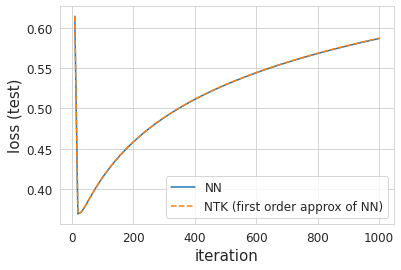

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")



plt.plot(10*np.arange(100)+10,np.array(l)[:,1],label = 'NN')
plt.plot(10*np.arange(100)+10,np.array(l)[:,3],label = 'NTK (first order approx of NN)',linestyle='dashed')

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('loss (test)',fontsize=15)

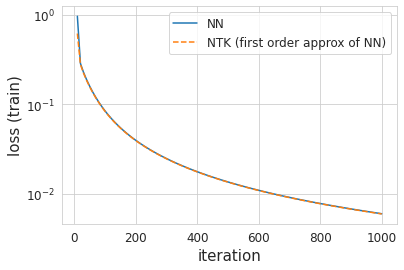

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")



plt.plot(10*np.arange(100)+10,np.array(l)[:,0],label = 'NN')
plt.plot(10*np.arange(100)+10,np.array(l)[:,2],label = 'NTK (first order approx of NN)',linestyle='dashed')

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('iteration',fontsize=15)
plt.ylabel('loss (train)',fontsize=15)
plt.yscale('log')

In [16]:
from sklearn.datasets import make_classification
import torch
import numpy as np
import random
from torch import optim, nn
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np

SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [17]:

transform = transforms.Compose([
        transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transform),
    batch_size=128, shuffle=True)

## Real data (MNIST)

In [18]:
from models import train_ntk
h_dim = 1000
alpha_set = [h_dim**(0.1*k) for k in range(11)]
alpha = alpha_set[5]
train_epoch = 50
_,a,l = train_ntk(train_loader,test_loader,h_dim,alpha,train_epoch,.1)

epoch 0 loss (train,test):2.31e-01;2.32e-01 acc:0.930200
dtheta: 0.011162119
du: 4.029753311078327
epoch 1 loss (train,test):1.93e-01;2.12e-01 acc:0.937600
dtheta: 0.018557396
du: 5.026208062970232
epoch 2 loss (train,test):1.58e-01;2.03e-01 acc:0.939200
dtheta: 0.02614915
du: 5.777089491188915
epoch 3 loss (train,test):1.71e-01;1.96e-01 acc:0.940900
dtheta: 0.033834305
du: 6.394309532610455
epoch 4 loss (train,test):1.15e-01;1.91e-01 acc:0.939700
dtheta: 0.04163611
du: 6.919676363740534
epoch 5 loss (train,test):1.39e-01;1.90e-01 acc:0.941000
dtheta: 0.049522154
du: 7.39364906941476
epoch 6 loss (train,test):1.56e-01;1.84e-01 acc:0.945200
dtheta: 0.057415307
du: 7.813726905835336
epoch 7 loss (train,test):9.76e-02;1.80e-01 acc:0.944800
dtheta: 0.06528688
du: 8.196228086252248
epoch 8 loss (train,test):1.02e-01;1.82e-01 acc:0.946800
dtheta: 0.073113516
du: 8.551930265111169
epoch 9 loss (train,test):1.27e-01;1.79e-01 acc:0.945800
dtheta: 0.080909416
du: 8.882555266010582
epoch 10 loss 

### Loss on MNIST

The linear approximation of NN on MNIST performs well at first, but then differs from the NN function. 
This suggests that some complex data cannot be fitted well by linear approxmation (NTK).

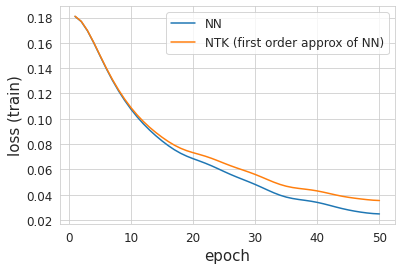

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from scipy.ndimage.filters import gaussian_filter1d

plt.plot(np.arange(50)+1,gaussian_filter1d(np.array(l)[:,0], sigma=3),label = 'NN')
plt.plot(np.arange(50)+1,gaussian_filter1d(np.array(l)[:,2], sigma=3),label = 'NTK (first order approx of NN)')



plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('loss (train)',fontsize=15)
#plt.savefig('loss_tr_ntk__.pdf')

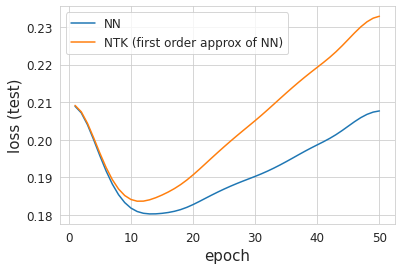

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")



plt.plot(np.arange(50)+1,gaussian_filter1d(np.array(l)[:,1], sigma=3),label = 'NN')
plt.plot(np.arange(50)+1,gaussian_filter1d(np.array(l)[:,3], sigma=3),label = 'NTK (first order approx of NN)')



plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('loss (test)',fontsize=15)
#plt.savefig('loss_te_ntk__.pdf')